In [1]:
#importing the libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import sys,os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the data
mnist = tf.keras.datasets.mnist

(X_train, y_train),(X_test,y_test) = mnist.load_data()

# chnage data between +1 to -1 for better training

X_train, X_test = X_train/255 *2 -1, X_test/255 *2 -1

print (X_train.shape)
print (X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Flatten the data

N, H, W = X_train.shape

D = H*W

X_train = X_train.reshape(-1,D)
X_test = X_test.reshape(-1,D)

print(X_train.shape)

(60000, 784)


In [4]:
# dimensionality of the latent space

latent_dim = 500

In [5]:
# build the generator model

def build_generator (latent_dim):
    i = Input (shape = (latent_dim, ))
    x = Dense (256, activation = LeakyReLU(alpha = 0.2))(i)
    x = BatchNormalization ( momentum = 0.8)(x)
    x = Dense (512, activation = LeakyReLU(alpha = 0.2))(x)
    x = BatchNormalization ( momentum = 0.8)(x)
    x = Dense (1024, activation = LeakyReLU(alpha = 0.2))(x)
    x = BatchNormalization ( momentum = 0.8)(x)
    x = Dense (D, activation = 'tanh')(x)
    
    model = Model(i,x)
    
    return model

In [6]:
# build the discriminator model

def build_discriminator (img_size):
    i = Input (shape = (img_size, ))
    x = Dense (512, activation = LeakyReLU(alpha = 0.2))(i)
    x = Dense (256, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dense (1, activation = 'sigmoid')(x)
    
    model = Model(i,x)
    
    return model

In [7]:
# compile both models for training

# build and compile the discriminator

discriminator = build_discriminator(D)

discriminator.compile (loss = 'binary_crossentropy', optimizer = Adam(0.0002,0.5), metrics = ['accuracy'])

#build and compile the combined model

generator = build_generator(latent_dim)

#create an input to get noise sample from latent space

z = Input (shape=(latent_dim, ))

# pass noise through generator to get an image

img = generator(z)

#make sure only generator is trained

discriminator.trainable = False

# the true output is fake, but we label them real

fake_pred = discriminator(img)

# create the combined model object

combined_model = Model (z, fake_pred)

#compile the combined model

combined_model.compile(loss= 'binary_crossentropy', optimizer = Adam(0.0002,0.5))

In [8]:
# train the GAN

epochs = 30000
sample_period = 200      #each sample period step generates and saves some data
batch_size = 32

#create batch labels to use when calling train on batch

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#store the losses

d_losses =[]
g_losses = []

# create a folder to save gan images

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [9]:
# generate a grid of random samples from generator and save them to a file

def sample_images(epoch):
    rows, cols = 5,5
    noise = np.random.randn (rows*cols, latent_dim)
    imgs = generator.predict(noise)
    
    #rescale images 0 to 1
    
    imgs = 0.5*imgs +0.5
    
    fig,axs = plt.subplots(rows,cols)
    idx = 0
    for i in range (rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H,W), cmap = 'gray')
            axs[i,j].axis('off')
            idx += 1
        fig.savefig('gan_images/%d.png' %epoch)
        plt.close()

In [10]:
# main training loop

for epoch in range (epochs):
    
    #train discriminator
    #select a random batch of images
    
    idx = np.random.randint(0, X_train.shape[0],batch_size)
    real_imgs = X_train[idx]
    
    # generate fake images
    noise = np.random.randn(batch_size,latent_dim)
    fake_imgs = generator.predict(noise)
    
    #train the discrimantor
    #both loss and accuracy is returned
    
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs,ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)
    d_loss = 0.5 *(d_loss_real +d_loss_fake)
    d_acc = 0.5 *(d_acc_real +d_acc_fake)
    
    #train generator
    
    noise = np.random.randn(batch_size,latent_dim)
    g_loss = combined_model.train_on_batch(noise,ones)
    
    #save the losses
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 ==0:
        print(f'epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}')
    
    if epoch % sample_period ==0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.69, d_acc: 0.44, g_loss: 0.69
epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.68
epoch: 201/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.81
epoch: 301/30000, d_loss: 0.05, d_acc: 1.00, g_loss: 4.89
epoch: 401/30000, d_loss: 0.75, d_acc: 0.50, g_loss: 1.29
epoch: 501/30000, d_loss: 0.61, d_acc: 0.69, g_loss: 0.99
epoch: 601/30000, d_loss: 0.64, d_acc: 0.66, g_loss: 0.88
epoch: 701/30000, d_loss: 0.64, d_acc: 0.67, g_loss: 0.79
epoch: 801/30000, d_loss: 0.62, d_acc: 0.75, g_loss: 0.77
epoch: 901/30000, d_loss: 0.65, d_acc: 0.66, g_loss: 0.78
epoch: 1001/30000, d_loss: 0.62, d_acc: 0.69, g_loss: 0.82
epoch: 1101/30000, d_loss: 0.59, d_acc: 0.69, g_loss: 0.86
epoch: 1201/30000, d_loss: 0.60, d_acc: 0.69, g_loss: 0.89
epoch: 1301/30000, d_loss: 0.59, d_acc: 0.73, g_loss: 0.86
epoch: 1401/30000, d_loss: 0.53, d_acc: 0.83, g_loss: 0.86
epoch: 1501/30000, d_loss: 0.57, d_acc: 0.75, g_loss: 0.95
epoch: 1601/30000, d_loss: 0.58, d_acc: 0.73, g_loss: 0.97
epoch: 17

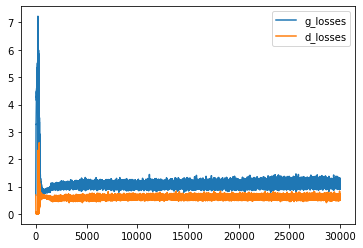

In [11]:
plt.plot (g_losses, label = 'g_losses')
plt.plot (d_losses, label = 'd_losses')

plt.legend()

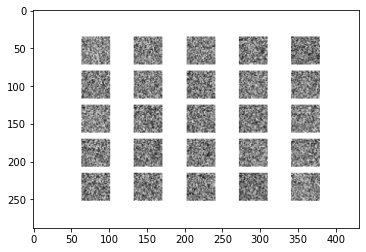

In [13]:
from skimage.io import imread

a = imread('gan_images/0.png')
plt.imshow(a)

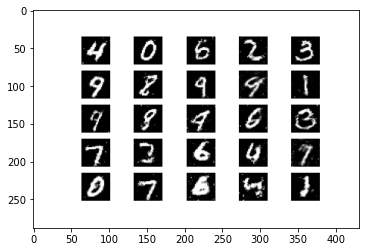

In [14]:
a = imread('gan_images/29800.png')
plt.imshow(a)